In this file I analysis fMRI data with graph metrics. 

I consider two types

1. corr FC with fisher transform and taking abs

2. binary FC via MST. 

with yeo's 7 networks


In [1]:
import sys
sys.path.append("../mypkg")

In [2]:
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT
from utils.misc import load_pkl, save_pkl, get_ball_cor
from utils.colors import qual_cmap

In [3]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [4]:
import numpy as np
import scipy
from scipy.io import loadmat
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
import bct # the pkg to get graph features
from joblib import Parallel, delayed
from easydict import EasyDict as edict
import pandas as pd

plt.style.use(FIG_ROOT/'base.mplstyle')

# Fns and params

## Some fns

In [5]:
from prettytable import PrettyTable as PT
from scipy.stats import f_oneway, ttest_ind 

def _get_test_tb(res_df):
    tb = PT()
    tb.field_names = ["Test", "Pval", "Effect size"]
    
    HC = res_df["metric"][res_df["diagnosis"]==6]
    
    def indicator(pval):
        if pval < 0.05:
            return "*"
        else:
            return ""
    # list all disease
    for diag_ix in range(1, 6):
        DS = res_df["metric"][res_df["diagnosis"]==diag_ix]
        ttest_res = ttest_ind(DS, HC)
        effect_size = (np.mean(DS)-np.mean(HC))/np.std(np.concatenate([DS, HC]), ddof=2)
        tb.add_row([f"{indicator(ttest_res.pvalue)}{diag_lab_mapping[diag_ix]} vs HC", 
                      f"{ttest_res.pvalue:>6.3f}", 
                      f"{effect_size:>6.3f}"])
    
    # pool 5 diseases together
    DS = res_df["metric"][res_df["diagnosis"]!=6]
    ttest_res = ttest_ind(DS, HC)
    effect_size = (np.mean(DS)-np.mean(HC))/np.std(np.concatenate([DS, HC]), ddof=2)
    tb.add_row([f"{indicator(ttest_res.pvalue)}Dementia vs HC", 
                f"{ttest_res.pvalue:>6.3f}", 
                f"{effect_size:>6.3f}"])
    
    # anova
    metric_grp = [res_df["metric"][res_df["diagnosis"]==grp_ix] for grp_ix in range(1, 7)]
    anova_res = f_oneway(*metric_grp)
    tb.add_row([f"{indicator(anova_res.pvalue)}ANOVA", 
                f"{anova_res.pvalue:>6.3f}", 
                f""])
    tb.align["Test"] = "r"
    tb.align["Pval"] = "c"
    tb.align["Effect size"] = "c"
    return tb

In [6]:
def bin_fc(M, threshold_density=.1):
    """Binarize a fc to keep threshold_density of all edges and with MST
    """
    assert type(M) == np.ndarray, "Wrong type"
    # M = np.absolute(M) # We want negative correlations to be edges, too.
    # Set diagonal to -1.  This makes sure it is added last, and thus
    # will not screw up the algorithm below for adding edges.  We have
    # ndarrays, so this is component-wise multiplication, not actual
    # matrix multiplication.
    M = (1-np.eye(M.shape[0], dtype='int'))*M + -1*np.eye(M.shape[0])
    # Now we threshold it.  We start with a minimum spanning tree to
    # ensure there are no disconnected nodes.  The cryptic square root
    # stuff gives it ultrametricity.
    MST = (np.asarray(scipy.sparse.csgraph.minimum_spanning_tree(np.sqrt(2*(1-M+1e-6))).todense()) != 0).astype(int)
    MST = MST + MST.T # Numpy routine doesn't make the result symmetric
    M = (1-MST)*M + -1*MST # Set MST to -1, like above w/ diagonal.
    Tri = np.triu(M) # Remove duplicate elements for symmetric matrix
    Rks = np.reshape(scipy.stats.rankdata(Tri, method='min'), Tri.shape) #Order them
    Rks = 1+np.max(Rks)-Rks # +1 so they start at 1, not 0
    # Correct for MST edges, the absence of a diagonal.  Divide by 2
    # for undirected graph, since we are only considering a triangular
    # matrix.
    conns_to_add = (M.shape[0]*(M.shape[0]-1)/2)*threshold_density - (M.shape[0]-1)
    newconns = Rks<=conns_to_add
    newconns = np.logical_or(newconns, newconns.T)
    Gmat = np.logical_or(MST, newconns)
    return np.asarray(Gmat).astype(int)

In [7]:
def _get_dmat(mat):
    dmat = mat + np.eye(mat.shape[0])
    dmat = 1/dmat
    np.fill_diagonal(dmat, np.inf)
    return dmat
    
def shuffle_sysmat(mat):
    """
    Shuffles the lower triangular elements of a matrix and returns a symmetric matrix with shuffled elements.

    Parameters:
    mat (numpy.ndarray): The input matrix.

    Returns:
    numpy.ndarray: A symmetric matrix with shuffled lower triangular elements and shuffled diagonal elements.
    """
    mat = mat.copy()
    trlMask1 = np.tril(np.ones_like(mat), k=-1)
    eles = mat[trlMask1==1]
    np.random.shuffle(eles)
    sMat = np.zeros_like(mat)
    sMat[trlMask1==1] = eles
    diag_vs = np.diag(mat)
    np.random.shuffle(diag_vs)
    sMat = sMat + sMat.T + np.diag(diag_vs)
    return sMat
    
def get_netmetrics(mat, nrep=50, show_prog=False):
    """
    Calculates various network measures for a given adjacency matrix.

    Parameters:
    mat (numpy.ndarray): The adjacency matrix of the network.
    nrep (int): The number of times to shuffle the matrix to calculate random measures.
    show_prog (bool): Whether to show a progress bar during the shuffling process.

    Returns:
    dict: A dictionary containing the following network measures:
        - tmC: The ratio of the mean clustering coefficient of the network to the mean clustering coefficient of the shuffled networks.
        - tmL: The ratio of the mean shortest path length of the network to the mean shortest path length of the shuffled networks.
        - tQ: The ratio of the modularity of the network to the modularity of the shuffled networks.
        - mC: The mean clustering coefficient of the network.
        - mL: The mean shortest path length of the network.
        - Q: The modularity of the network.
    """
    Cs = bct.clustering_coef_wu(mat)
    mC = np.mean(Cs)
    Ls = bct.distance_wei(_get_dmat(mat))[0]
    mL = 1/np.mean(1/Ls[np.eye(Ls.shape[0])!=1])
    _, Q = bct.modularity_und(mat)
    
    ranLs = []
    ranQs = []
    ranCs = []
    if show_prog:
        pbar = trange(nrep)
    else:
        pbar = range(nrep)
    for i in pbar:
        sMat = shuffle_sysmat(mat)
        Cs = bct.clustering_coef_wu(sMat)
        mCi = np.mean(Cs)
        ranCs.append(mCi)
        Ls = bct.distance_wei(_get_dmat(sMat))[0]
        mLi = 1/np.mean(1/Ls[np.eye(Ls.shape[0])!=1])
        ranLs.append(mLi)
        _, Qi = bct.modularity_und(sMat)
        ranQs.append(Qi)
    
    tQ = Q/np.mean(ranQs)
    tmL  = mL/np.mean(ranLs)
    tmC  = mC/np.mean(ranCs)
    return {
        "tmC": tmC, 
        "tmL": tmL, 
        "tQ": tQ, 
        "mC": mC, 
        "mL": mL, 
        "Q": Q, }
    
def get_netmetrics_bin(mat, nrep=50, show_prog=False):
    """
    Calculates various network measures for a given binary adjacency matrix.

    Parameters:
    mat (numpy.ndarray): The adjacency matrix of the network.
    nrep (int): The number of times to shuffle the matrix to calculate random measures.
    show_prog (bool): Whether to show a progress bar during the shuffling process.

    Returns:
    dict: A dictionary containing the following network measures:
        - tmC: The ratio of the mean clustering coefficient of the network to the mean clustering coefficient of the shuffled networks.
        - tmL: The ratio of the mean shortest path length of the network to the mean shortest path length of the shuffled networks.
        - tQ: The ratio of the modularity of the network to the modularity of the shuffled networks.
        - mC: The mean clustering coefficient of the network.
        - mL: The mean shortest path length of the network.
        - Q: The modularity of the network.
    """
    Cs = bct.clustering_coef_bu(mat)
    mC = np.mean(Cs)
    Ls = bct.distance_bin(mat)
    mL = 1/np.mean(1/Ls[np.eye(Ls.shape[0])!=1])
    _, Q = bct.modularity_und(mat)
    
    ranLs = []
    ranQs = []
    ranCs = []
    if show_prog:
        pbar = trange(nrep)
    else:
        pbar = range(nrep)
    for i in pbar:
        sMat = shuffle_sysmat(mat)
        Cs = bct.clustering_coef_bu(sMat)
        mCi = np.mean(Cs)
        ranCs.append(mCi)
        Ls = bct.distance_bin(sMat)
        mLi = 1/np.mean(1/Ls[np.eye(Ls.shape[0])!=1])
        ranLs.append(mLi)
        _, Qi = bct.modularity_und(sMat)
        ranQs.append(Qi)
    
    tQ = Q/np.mean(ranQs)
    tmL  = mL/np.mean(ranLs)
    tmC  = mC/np.mean(ranCs)
    return {
        "tmC": tmC, 
        "tmL": tmL, 
        "tQ": tQ, 
        "mC": mC, 
        "mL": mL, 
        "Q": Q, }

In [8]:
def _preprocess_ts(ts):
    """preprocessing, 
        1. detrend
        2. resample (len of seq has 235 or 555, I make it consistent to 235)
    """
    ts = signal.detrend(ts);
    if ts.shape[-1] > 235:
        ts = signal.resample(ts, num=235, axis=-1)
    return ts
    
def _get_fc(ts, is_fisher=True):
    """Get FC from ts, including 
        1. Pearsons'r 
        2. fisher transform
        3. abs value
    """
    fc = np.corrcoef(ts)
    fc = fc - np.diag(np.diag(fc))
    if is_fisher:
        fc = np.arctanh(fc)
    fc = np.abs(fc)
    return fc

def _get_binfc(ts):
    """Get FC from ts, including 
        1. Pearsons'r 
    """
    fc = np.corrcoef(ts)
    fc = fc - np.diag(np.diag(fc))
    return bin_fc(fc)
    
def _load_data(n):
    """Sub idx is from 1, n: the sub idx
    """
    return mat_data['ts_321_273'][np.where(mat_data['subj_321_ts'][:, 0] == n)[0], :].transpose()

## Load data and params

In [9]:
# load data
mat_data = loadmat(DATA_ROOT/"ad_ftd_hc_fmri_data.mat");

# some parameters

num_rois = 246 # the BNA has 246 regions
num_sps = 321

labs = pd.read_csv(DATA_ROOT/"BN246_RegionList.csv");
yeo_7nets_lab = np.array(labs["Yeo_7network"][:246]);

yeo_7nets_dict = pd.read_csv(DATA_ROOT/"yeo_7nets_dict.txt");
yeo_7nets_dict = {yeo_7nets_dict["lab"][ix]:"_".join(yeo_7nets_dict["name"][ix].strip().split(" "))
                  for ix in range(7)}
yeo_7nets_ts = load_pkl(DATA_ROOT/"ad_ftd_hc_fmri_data_7nets.pkl");

Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../data/ad_ftd_hc_fmri_data_7nets.pkl


# Get network(graph) metrics

In [13]:
def _run_fn(sub_ix):
    ts = cur_tss[sub_ix-1]
    fc = _get_fc(ts, is_fisher=True);
    res = edict()
    res.sub_ix = sub_ix 
    res.fc = fc
    res.network_metrics = get_netmetrics(fc)
    return res


In [14]:
for net_ix in range(1, 8):
    with Parallel(n_jobs=15) as parallel:
        cur_tss = yeo_7nets_ts[yeo_7nets_dict[net_ix]]
        res = parallel(delayed(_run_fn)(sub_ix) for sub_ix in tqdm(range(1, num_sps+1), total=num_sps))
    save_pkl(RES_ROOT/f"graph_metrics_fc_fisher_abs_{yeo_7nets_dict[net_ix]}.pkl", res, is_force=True)

  5%|██████▍                                                                                                                                  | 15/321 [00:00<00:06, 43.91it/s]/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.

Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/graph_metrics_fc_fisher_abs_Visual.pkl


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [02:08<00:00,  2.50it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/graph_metrics_fc_fisher_abs_Somatomotor.pkl


 56%|████████████████████████████████████████████████████████████████████████████▎                                                           | 180/321 [00:59<00:53,  2.66it/s]/opt/conda/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
 61%|██████████████████████████████████████████████████████████████████████████████████▌                                                     | 195/321 [01:05<00:47,  2.65it/s]/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
100%|███████████████

Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/graph_metrics_fc_fisher_abs_Dorsal_Attention.pkl


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [01:02<00:00,  5.12it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/graph_metrics_fc_fisher_abs_Ventral_Attention.pkl


 23%|████████████████████████████████                                                                                                         | 75/321 [00:15<00:58,  4.20it/s]/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
 37%|██████████████████████████████████████████████████▊                                                                                     | 120/321 [00:29<00:57,  3.50it/s]/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do

Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/graph_metrics_fc_fisher_abs_Limbic.pkl


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [01:25<00:00,  3.77it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/graph_metrics_fc_fisher_abs_Frontoparietal.pkl


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [02:33<00:00,  2.09it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/graph_metrics_fc_fisher_abs_Default.pkl


Save to /MyResearch/jesse_data/notebooks/../mypkg/../results/graph_metrics_fc_fisher_abs.pkl


## Analyasis

In [26]:
from scipy.stats import f_oneway, ttest_ind 
diag_labs = mat_data["dx_321"].reshape(-1)
sex_labs = mat_data["sex_321"].reshape(-1)
diag_lab_mapping = {
 1: "AD",
 2: "bvFTD",
 3: "CBS", 
 4: "nfvPPA", 
 5: "svPPA", 
 6: "HC"
}

{1: 'AD', 2: 'bvFTD', 3: 'CBS', 4: 'nfvPPA', 5: 'svPPA', 6: 'HC'}

In [96]:
net_ix =2
res = load_pkl(RES_ROOT/f"graph_metrics_fc_fisher_abs_{yeo_7nets_dict[net_ix]}.pkl");

Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/graph_metrics_fc_fisher_abs_Somatomotor.pkl


<AxesSubplot:>

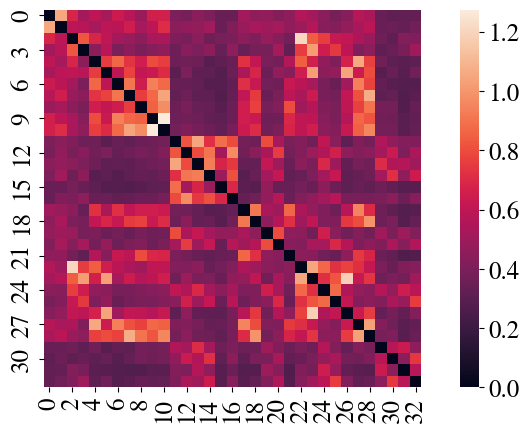

In [97]:
# let check fc, the order should be left-right-alternative
fcs = np.array([re["fc"] for re in res])

mfc = fcs.mean(axis=0)
sns.heatmap(mfc, square=1)

Metric is tmC
+-----------------+--------+-------------+
|            Test |  Pval  | Effect size |
+-----------------+--------+-------------+
|        AD vs HC |  0.134 |     0.223   |
|    *bvFTD vs HC |  0.038 |     0.382   |
|       CBS vs HC |  0.372 |     0.194   |
|   *nfvPPA vs HC |  0.002 |     0.616   |
|    *svPPA vs HC |  0.000 |     0.947   |
| *Dementia vs HC |  0.000 |     0.430   |
|          *ANOVA |  0.000 |             |
+-----------------+--------+-------------+


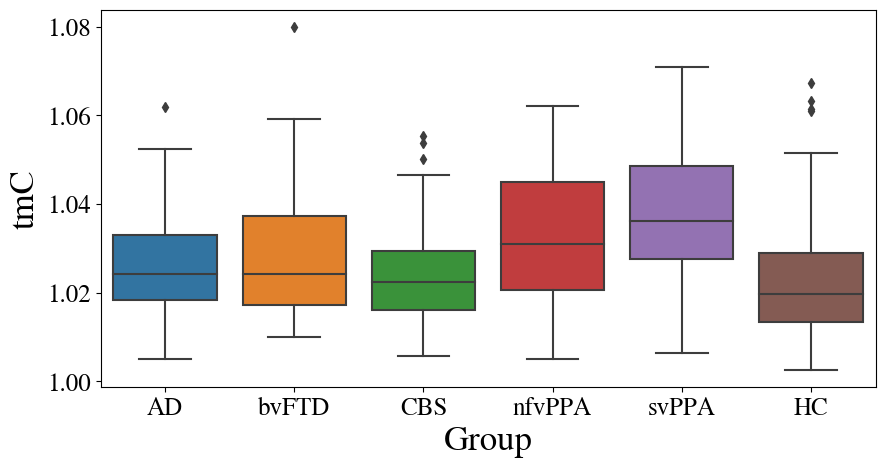

In [98]:
metric = "tmC"
sub_ixs = np.array([re["sub_ix"] for re in res])
metrics = np.array([re["network_metrics"][metric] for re in res])
metrics = metrics[np.argsort(sub_ixs)]
res_df = pd.DataFrame({
    "metric": metrics, 
    "sex": sex_labs, 
    "diagnosis": diag_labs
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
sns.boxplot(data=res_df, x="diagnosis1", y="metric")
plt.xlabel("Group")
plt.ylabel(f"{metric}")
print(f"Metric is {metric}")
print(_get_test_tb(res_df))

Metric is tmL
+-----------------+--------+-------------+
|            Test |  Pval  | Effect size |
+-----------------+--------+-------------+
|       *AD vs HC |  0.043 |     0.300   |
|    *bvFTD vs HC |  0.027 |     0.408   |
|       CBS vs HC |  0.081 |     0.377   |
|   *nfvPPA vs HC |  0.017 |     0.470   |
|    *svPPA vs HC |  0.000 |     0.845   |
| *Dementia vs HC |  0.000 |     0.456   |
|          *ANOVA |  0.000 |             |
+-----------------+--------+-------------+


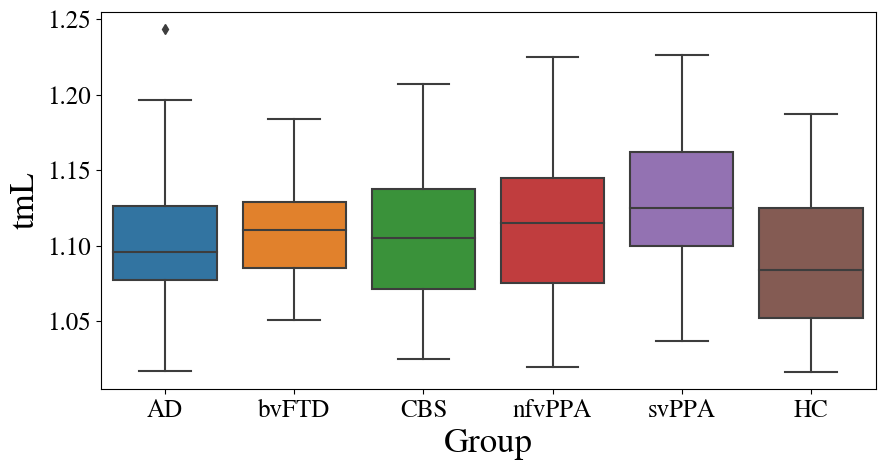

In [99]:
metric = "tmL"
sub_ixs = np.array([re["sub_ix"] for re in res])
metrics = np.array([re["network_metrics"][metric] for re in res])
metrics = metrics[np.argsort(sub_ixs)]
res_df = pd.DataFrame({
    "metric": metrics, 
    "sex": sex_labs, 
    "diagnosis": diag_labs
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
sns.boxplot(data=res_df, x="diagnosis1", y="metric")
plt.xlabel("Group")
plt.ylabel(f"{metric}")
print(f"Metric is {metric}")
print(_get_test_tb(res_df))

Metric is tQ
+-----------------+--------+-------------+
|            Test |  Pval  | Effect size |
+-----------------+--------+-------------+
|        AD vs HC |  0.301 |    -0.154   |
|     bvFTD vs HC |  0.124 |    -0.285   |
|       CBS vs HC |  0.313 |    -0.219   |
|   *nfvPPA vs HC |  0.026 |    -0.438   |
|    *svPPA vs HC |  0.003 |    -0.558   |
| *Dementia vs HC |  0.008 |    -0.318   |
|          *ANOVA |  0.023 |             |
+-----------------+--------+-------------+


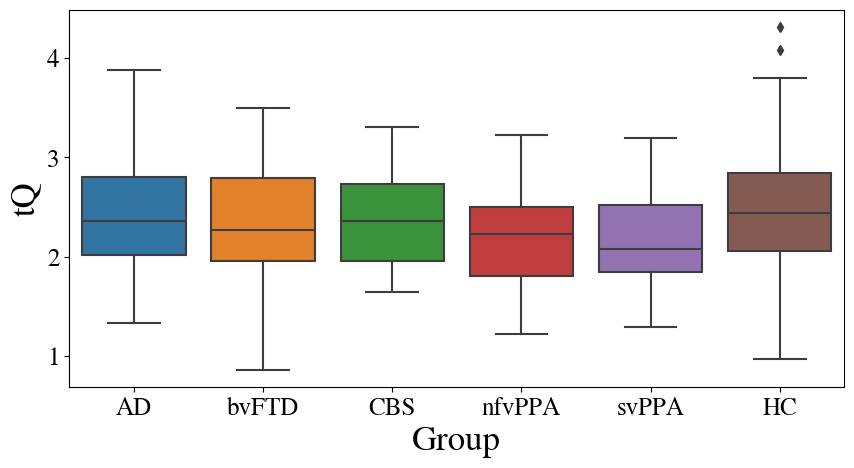

In [100]:
metric = "tQ"
sub_ixs = np.array([re["sub_ix"] for re in res])
metrics = np.array([re["network_metrics"][metric] for re in res])
metrics = metrics[np.argsort(sub_ixs)]
res_df = pd.DataFrame({
    "metric": metrics, 
    "sex": sex_labs, 
    "diagnosis": diag_labs
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
sns.boxplot(data=res_df, x="diagnosis1", y="metric")
plt.xlabel("Group")
plt.ylabel(f"{metric}")
print(f"Metric is {metric}")
print(_get_test_tb(res_df))

In [24]:
sub_ixs = np.array([re["sub_ix"] for re in res])
metricss = np.array([(re["network_metrics"]["tmC"], re["network_metrics"]["tmL"], re["network_metrics"]["tQ"])
                     for re in res])
metricss = metricss[np.argsort(sub_ixs)]
cmap = plt.cm.get_cmap('Set1')
cols = cmap(np.linspace(0, 1, len(set(diag_labs))))
graph_metric_labs = ["tmC", "tmL", "tQ"]

['tmC', 'tmL', 'tQ']

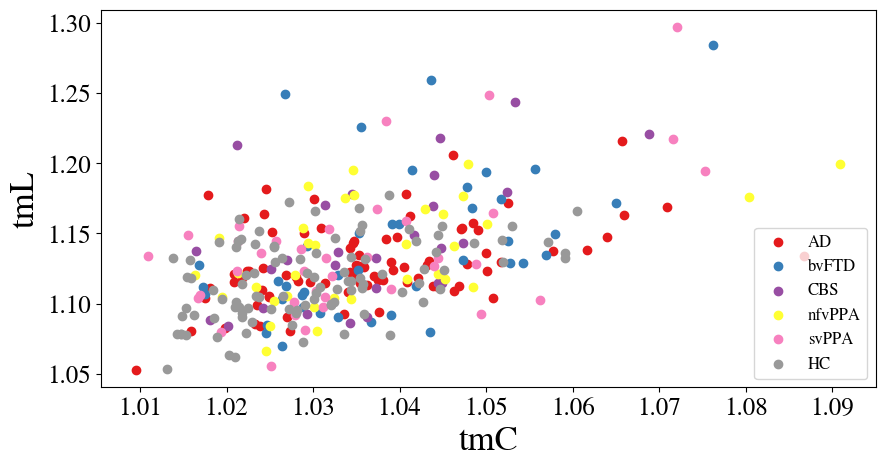

In [25]:
xix = 0
yix = 1
for ix in range(1, len(set(diag_labs))+1):
    plt.scatter(x=metricss[diag_labs==ix, xix], y=metricss[diag_labs==ix, yix], color=cols[ix-1], label=diag_lab_mapping[ix])
plt.xlabel(graph_metric_labs[xix])
plt.ylabel(graph_metric_labs[yix])
plt.legend(loc="lower right", fontsize=12)

# Get binary network(graph) metrics

In [64]:
def _run_fn(sub_ix):
    ts = cur_tss[sub_ix-1]
    fc = _get_binfc(ts)
    res = edict()
    res.sub_ix = sub_ix 
    res.fc = fc
    res.network_metrics = get_netmetrics_bin(fc)
    return res


In [65]:
for net_ix in range(1, 8):
    with Parallel(n_jobs=15) as parallel:
        cur_tss = yeo_7nets_ts[yeo_7nets_dict[net_ix]]
        res = parallel(delayed(_run_fn)(sub_ix) for sub_ix in tqdm(range(1, num_sps+1), total=num_sps))
    save_pkl(RES_ROOT/f"graph_metrics_bfc_{yeo_7nets_dict[net_ix]}.pkl", res, is_force=True)

  5%|██████▍                                                                                                                                  | 15/321 [00:00<00:13, 22.95it/s]/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.

Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/graph_metrics_bfc_Visual.pkl


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:40<00:00,  7.95it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/graph_metrics_bfc_Somatomotor.pkl


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 270/321 [00:30<00:06,  8.31it/s]/opt/conda/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 300/321 [00:33<00:02,  8.39it/s]/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
100%|███████████████

Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/graph_metrics_bfc_Dorsal_Attention.pkl


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:26<00:00, 12.18it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/graph_metrics_bfc_Ventral_Attention.pkl


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:28<00:00, 11.21it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/graph_metrics_bfc_Limbic.pkl


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:28<00:00, 11.31it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/graph_metrics_bfc_Frontoparietal.pkl


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:42<00:00,  7.49it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/graph_metrics_bfc_Default.pkl


## Analysis

In [66]:
diag_labs = mat_data["dx_321"].reshape(-1)
sex_labs = mat_data["sex_321"].reshape(-1)
diag_lab_mapping = {
 1: "AD",
 2: "bvFTD",
 3: "CBS", 
 4: "nfvPPA", 
 5: "svPPA", 
 6: "HC"
}

{1: 'AD', 2: 'bvFTD', 3: 'CBS', 4: 'nfvPPA', 5: 'svPPA', 6: 'HC'}

In [92]:
net_ix = 7
res = load_pkl(RES_ROOT/f"graph_metrics_bfc_{yeo_7nets_dict[net_ix]}.pkl");

Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/graph_metrics_bfc_Default.pkl


Metric is tmC
+----------------+--------+-------------+
|           Test |  Pval  | Effect size |
+----------------+--------+-------------+
|       AD vs HC |  0.357 |    -0.137   |
|    bvFTD vs HC |  0.206 |    -0.234   |
|      CBS vs HC |  0.268 |    -0.240   |
|   nfvPPA vs HC |  0.844 |     0.039   |
|    svPPA vs HC |  0.677 |    -0.080   |
| Dementia vs HC |  0.266 |    -0.134   |
|          ANOVA |  0.667 |             |
+----------------+--------+-------------+


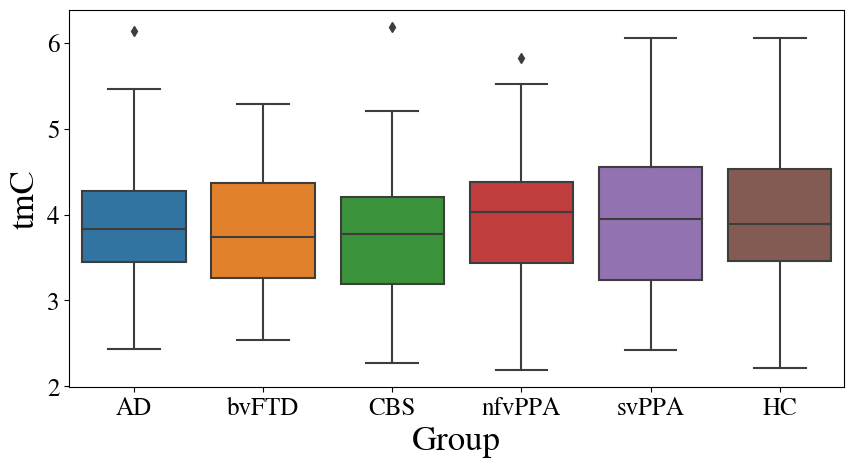

In [93]:
metric = "tmC"
sub_ixs = np.array([re["sub_ix"] for re in res])
metrics = np.array([re["network_metrics"][metric] for re in res])
metrics = metrics[np.argsort(sub_ixs)]
res_df = pd.DataFrame({
    "metric": metrics, 
    "sex": sex_labs, 
    "diagnosis": diag_labs
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
sns.boxplot(data=res_df, x="diagnosis1", y="metric")
plt.xlabel("Group")
plt.ylabel(f"{metric}")
print(f"Metric is {metric}")
print(_get_test_tb(res_df))

Metric is tmL
+----------------+--------+-------------+
|           Test |  Pval  | Effect size |
+----------------+--------+-------------+
|       AD vs HC |  0.741 |     0.049   |
|    bvFTD vs HC |  0.667 |     0.080   |
|     *CBS vs HC |  0.034 |     0.457   |
|   nfvPPA vs HC |  0.115 |     0.312   |
|   *svPPA vs HC |  0.017 |     0.455   |
| Dementia vs HC |  0.074 |     0.215   |
|          ANOVA |  0.054 |             |
+----------------+--------+-------------+


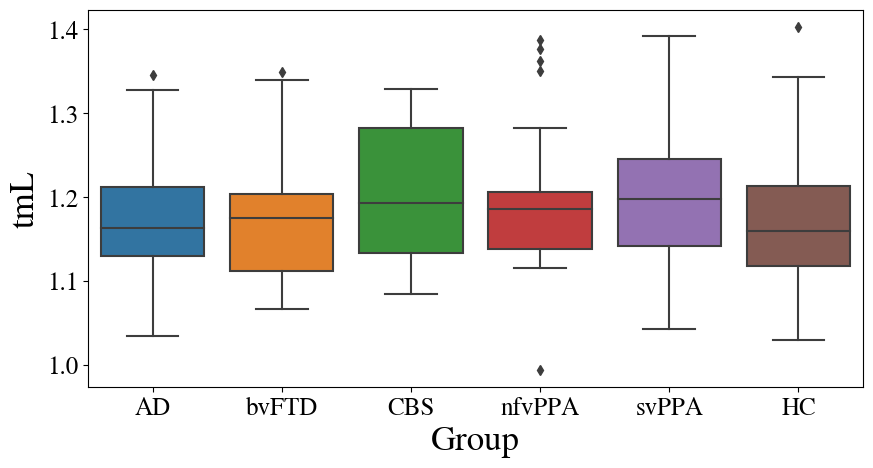

In [94]:
metric = "tmL"
sub_ixs = np.array([re["sub_ix"] for re in res])
metrics = np.array([re["network_metrics"][metric] for re in res])
metrics = metrics[np.argsort(sub_ixs)]
res_df = pd.DataFrame({
    "metric": metrics, 
    "sex": sex_labs, 
    "diagnosis": diag_labs
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
sns.boxplot(data=res_df, x="diagnosis1", y="metric")
plt.xlabel("Group")
plt.ylabel(f"{metric}")
print(f"Metric is {metric}")
print(_get_test_tb(res_df))

Metric is tQ
+----------------+--------+-------------+
|           Test |  Pval  | Effect size |
+----------------+--------+-------------+
|       AD vs HC |  0.833 |    -0.031   |
|    bvFTD vs HC |  0.780 |     0.052   |
|      CBS vs HC |  0.762 |     0.066   |
|   nfvPPA vs HC |  0.226 |     0.240   |
|    svPPA vs HC |  0.573 |    -0.109   |
| Dementia vs HC |  0.842 |     0.024   |
|          ANOVA |  0.758 |             |
+----------------+--------+-------------+


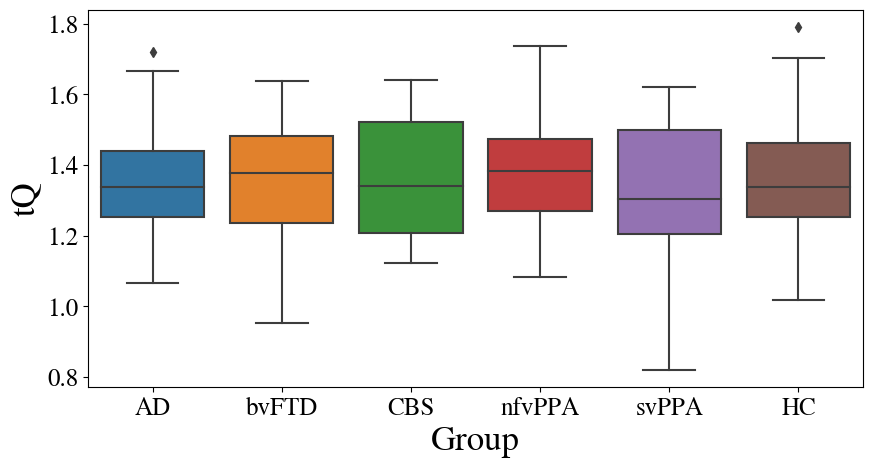

In [95]:
metric = "tQ"
sub_ixs = np.array([re["sub_ix"] for re in res])
metrics = np.array([re["network_metrics"][metric] for re in res])
metrics = metrics[np.argsort(sub_ixs)]
res_df = pd.DataFrame({
    "metric": metrics, 
    "sex": sex_labs, 
    "diagnosis": diag_labs
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
sns.boxplot(data=res_df, x="diagnosis1", y="metric")
plt.xlabel("Group")
plt.ylabel(f"{metric}")
print(f"Metric is {metric}")
print(_get_test_tb(res_df))

# Get ball corr FC 

In [10]:
def get_bcorr_FC(ts, verbose=False):
    """
    Calculates the ball correlation functional connectivity (bcorrFC) for a given time series.

    Parameters:
    ts (numpy.ndarray): A 2D numpy array of shape (num_rois, num_timepoints) containing the time series data.
    verbose (bool): If True, displays a progress bar while the function is running. Default is False.

    Returns:
    numpy.ndarray: A 2D numpy array of shape (num_rois, num_rois) containing the bcorrFC values.
                   The diag terms are 0.
    """
    num_rois = ts.shape[0]
    bcorFC = np.zeros((num_rois, num_rois));
    rixs, cixs = np.triu_indices(num_rois, k=1)
    def _run_fn(cix, rix, ts):
        return get_ball_cor(ts[rix], ts[cix])
    if verbose:
        pbar = tqdm(zip(rixs, cixs), total=len(rixs))
    else:
        pbar = zip(rixs, cixs)
    with Parallel(n_jobs=20) as parallel:
        bcors = parallel(delayed(_run_fn)(rix, cix, ts) for rix, cix in pbar)
    bcorFC[(rixs, cixs)] = np.array(bcors)
    bcorFC = bcorFC + bcorFC.T
    return bcorFC

In [11]:
bcorFCs = load_pkl(RES_ROOT/"bcorFCs.pkl");

Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/bcorFCs.pkl


In [14]:
def _run_fn(sub_ix, net_ix):
    bfc = bcorFCs[sub_ix-1]
    bfc = bfc[yeo_7nets_lab==net_ix][:, yeo_7nets_lab==net_ix]
    res = edict()
    res.sub_ix = sub_ix 
    res.fc = bfc 
    res.network_metrics = get_netmetrics(bfc)
    return res
for net_ix in range(1, 8):
    with Parallel(n_jobs=20) as parallel:
        res = parallel(delayed(_run_fn)(sub_ix, net_ix) for sub_ix in tqdm(range(1, num_sps+1), total=num_sps))
    save_pkl(RES_ROOT/f"graph_metrics_ballfc_{yeo_7nets_dict[net_ix]}.pkl", res, is_force=True)



  0%|                                                                                                                                                  | 0/321 [00:00<?, ?it/s]

  6%|████████▌                                                                                                                                | 20/321 [00:00<00:08, 33.54it/s]/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant t



 12%|█████████████████                                                                                                                        | 40/321 [00:15<00:36,  7.80it/s]

 19%|█████████████████████████▌                                                                                                               | 60/321 [00:17<01:33,  2.80it/s]

 25%|██████████████████████████████████▏                                                                                                      | 80/321 [00:28<01:46,  2.26it/s]/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


 31%|██████████████████████████████████████████▎                                    

Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/graph_metrics_ballfc_Visual.pkl




  0%|                                                                                                                                                  | 0/321 [00:00<?, ?it/s]

  6%|████████▌                                                                                                                                | 20/321 [00:00<00:03, 85.58it/s]/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


 12%|█████████████████                                                                                                                        | 40/321 [00:03<00:28,  9.89it/s]/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationW

/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 280/321 [02:23<00:24,  1.71it/s]/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.9/site-packages/numpy/core/_asarra

Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/graph_metrics_ballfc_Somatomotor.pkl




  0%|                                                                                                                                                  | 0/321 [00:00<?, ?it/s]

 12%|█████████████████                                                                                                                        | 40/321 [00:03<00:24, 11.65it/s]

 13%|█████████████████▉                                                                                                                       | 42/321 [00:03<00:23, 11.81it/s]/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


 19%|█████████████████████████▌                                                     

Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/graph_metrics_ballfc_Dorsal_Attention.pkl




  0%|                                                                                                                                                  | 0/321 [00:00<?, ?it/s]

  6%|████████▌                                                                                                                                | 20/321 [00:00<00:04, 67.10it/s]

 12%|█████████████████                                                                                                                        | 40/321 [00:02<00:16, 16.54it/s]/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


 19%|█████████████████████████▌                                                     

Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/graph_metrics_ballfc_Ventral_Attention.pkl




  0%|                                                                                                                                                  | 0/321 [00:00<?, ?it/s]

 12%|█████████████████                                                                                                                        | 40/321 [00:02<00:18, 15.50it/s]

 19%|█████████████████████████▌                                                                                                               | 60/321 [00:12<01:05,  4.00it/s]/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationW

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 280/321 [01:52<00:17,  2.29it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 300/321 [02:00<00:09,  2.31it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [02:09<00:00,  2.48it/s]
/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWa

Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/graph_metrics_ballfc_Limbic.pkl




  0%|                                                                                                                                                  | 0/321 [00:00<?, ?it/s]

 12%|█████████████████                                                                                                                        | 40/321 [00:02<00:19, 14.35it/s]

 19%|█████████████████████████▌                                                                                                               | 60/321 [00:11<00:56,  4.59it/s]

 25%|██████████████████████████████████▏                                                                                                      | 80/321 [00:19<01:11,  3.35it/s]

 31%|██████████████████████████████████████████▎                                                                                             | 100/321 [00:28<01:16,  2.89it/s]

 37%|██████████████████████████████████████████████████▊                                                         

Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/graph_metrics_ballfc_Frontoparietal.pkl




  0%|                                                                                                                                                  | 0/321 [00:00<?, ?it/s]

 12%|█████████████████                                                                                                                        | 40/321 [00:05<00:35,  8.03it/s]/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant t

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 240/321 [02:16<00:52,  1.53it/s]/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


 81%|████████████████████████████████████████████████████

Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/graph_metrics_ballfc_Default.pkl


In [15]:
def _run_fn(sub_ix, net_ix):
    bfc = bcorFCs[sub_ix-1]
    bfc = bfc[yeo_7nets_lab==net_ix][:, yeo_7nets_lab==net_ix]
    bbinfc = bin_fc(bfc)
    res = edict()
    res.sub_ix = sub_ix 
    res.fc = bbinfc
    res.network_metrics = get_netmetrics_bin(bbinfc)
    return res
for net_ix in range(1, 8):
    with Parallel(n_jobs=15) as parallel:
        res = parallel(delayed(_run_fn)(sub_ix, net_ix) for sub_ix in tqdm(range(1, num_sps+1), total=num_sps))
    save_pkl(RES_ROOT/f"graph_metrics_bbinfc_{yeo_7nets_dict[net_ix]}.pkl", res, is_force=True)



  0%|                                                                                                                                                  | 0/321 [00:00<?, ?it/s]/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


/opt/conda/lib/python3.9/site-packages/numpy/core/_asar

/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) 



 61%|██████████████████████████████████████████████████████████████████████████████████▌                                                     | 195/321 [01:15<00:56,  2.25it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████▉                                               | 210/321 [01:22<00:49,  2.25it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 225/321 [01:29<00:42,  2.26it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 240/321 [01:35<00:35,  2.26it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 255/321 [01:42<00:29,  2.24it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████

Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/graph_metrics_bbinfc_Visual.pkl




  0%|                                                                                                                                                  | 0/321 [00:00<?, ?it/s]

  9%|████████████▊                                                                                                                            | 30/321 [00:01<00:15, 19.22it/s]/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


 14%|███████████████████▏                                                                                                                     | 45/321 [00:08<01:03,  4.35it/s]/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationW

 61%|██████████████████████████████████████████████████████████████████████████████████▌                                                     | 195/321 [01:15<00:54,  2.29it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████                                                     | 196/321 [01:15<00:53,  2.35it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████▍                                                    | 197/321 [01:15<00:50,  2.44it/s]/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWar

Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/graph_metrics_bbinfc_Somatomotor.pkl




  0%|                                                                                                                                                  | 0/321 [00:00<?, ?it/s]

  9%|████████████▊                                                                                                                            | 30/321 [00:01<00:14, 20.03it/s]

 14%|███████████████████▏                                                                                                                     | 45/321 [00:07<00:57,  4.84it/s]

 19%|█████████████████████████▌                                                                                                               | 60/321 [00:14<01:16,  3.41it/s]

 19%|██████████████████████████                                                                                                               | 61/321 [00:14<01:14,  3.48it/s]

 23%|████████████████████████████████                                                                            



 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 255/321 [01:39<00:28,  2.29it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 256/321 [01:39<00:27,  2.35it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 270/321 [01:45<00:22,  2.28it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 271/321 [01:45<00:21,  2.34it/s]/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/graph_metrics_bbinfc_Dorsal_Attention.pkl




  0%|                                                                                                                                                  | 0/321 [00:00<?, ?it/s]

  5%|██████▍                                                                                                                                  | 15/321 [00:00<00:05, 57.81it/s]

  9%|████████████▊                                                                                                                            | 30/321 [00:01<00:14, 19.99it/s]/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


 14%|███████████████████▏                                                           

Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/graph_metrics_bbinfc_Ventral_Attention.pkl




  0%|                                                                                                                                                  | 0/321 [00:00<?, ?it/s]

  9%|████████████▊                                                                                                                            | 30/321 [00:01<00:13, 21.82it/s]

 14%|███████████████████▏                                                                                                                     | 45/321 [00:08<00:59,  4.64it/s]/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


 19%|█████████████████████████▌                                                     

Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/graph_metrics_bbinfc_Limbic.pkl




  0%|                                                                                                                                                  | 0/321 [00:00<?, ?it/s]

  9%|████████████▊                                                                                                                            | 30/321 [00:01<00:10, 26.65it/s]

 14%|███████████████████▏                                                                                                                     | 45/321 [00:07<00:54,  5.03it/s]

 19%|█████████████████████████▌                                                                                                               | 60/321 [00:13<01:13,  3.53it/s]

 23%|████████████████████████████████                                                                                                         | 75/321 [00:20<01:22,  3.00it/s]

 28%|██████████████████████████████████████▍                                                                     

Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/graph_metrics_bbinfc_Frontoparietal.pkl




  0%|                                                                                                                                                  | 0/321 [00:00<?, ?it/s]

  5%|██████▍                                                                                                                                  | 15/321 [00:00<00:03, 83.48it/s]

  7%|██████████▏                                                                                                                              | 24/321 [00:00<00:03, 83.56it/s]

 10%|██████████████                                                                                                                           | 33/321 [00:01<00:19, 14.77it/s]/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/graph_metrics_bbinfc_Default.pkl


## Analysis

### Bin FC

In [33]:
net_ix = 7
res = load_pkl(RES_ROOT/f"graph_metrics_bbinfc_{yeo_7nets_dict[net_ix]}.pkl");
diag_labs = mat_data["dx_321"].reshape(-1)
sex_labs = mat_data["sex_321"].reshape(-1)
diag_lab_mapping = {
 1: "AD",
 2: "bvFTD",
 3: "CBS", 
 4: "nfvPPA", 
 5: "svPPA", 
 6: "HC"
}


Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/graph_metrics_bbinfc_Default.pkl


{1: 'AD', 2: 'bvFTD', 3: 'CBS', 4: 'nfvPPA', 5: 'svPPA', 6: 'HC'}

In [34]:
metric = "tmC"
sub_ixs = np.array([re["sub_ix"] for re in res])
metrics = np.array([re["network_metrics"][metric] for re in res])
metrics = metrics[np.argsort(sub_ixs)]
res_df = pd.DataFrame({
    "metric": metrics, 
    "sex": sex_labs, 
    "diagnosis": diag_labs
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
print(f"Metric is {metric}")
print(_get_test_tb(res_df))

metric = "tmL"
sub_ixs = np.array([re["sub_ix"] for re in res])
metrics = np.array([re["network_metrics"][metric] for re in res])
metrics = metrics[np.argsort(sub_ixs)]
res_df = pd.DataFrame({
    "metric": metrics, 
    "sex": sex_labs, 
    "diagnosis": diag_labs
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
print(f"Metric is {metric}")
print(_get_test_tb(res_df))

metric = "tQ"
sub_ixs = np.array([re["sub_ix"] for re in res])
metrics = np.array([re["network_metrics"][metric] for re in res])
metrics = metrics[np.argsort(sub_ixs)]
res_df = pd.DataFrame({
    "metric": metrics, 
    "sex": sex_labs, 
    "diagnosis": diag_labs
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
print(f"Metric is {metric}")
print(_get_test_tb(res_df))

Metric is tmC
+----------------+--------+-------------+
|           Test |  Pval  | Effect size |
+----------------+--------+-------------+
|       AD vs HC |  0.366 |    -0.135   |
|    bvFTD vs HC |  0.369 |    -0.167   |
|      CBS vs HC |  0.632 |    -0.104   |
|   nfvPPA vs HC |  0.697 |     0.077   |
|    svPPA vs HC |  0.583 |    -0.106   |
| Dementia vs HC |  0.421 |    -0.097   |
|          ANOVA |  0.858 |             |
+----------------+--------+-------------+
Metric is tmL
+----------------+--------+-------------+
|           Test |  Pval  | Effect size |
+----------------+--------+-------------+
|       AD vs HC |  0.459 |     0.110   |
|    bvFTD vs HC |  0.601 |     0.097   |
|      CBS vs HC |  0.058 |     0.408   |
|  *nfvPPA vs HC |  0.016 |     0.473   |
|    svPPA vs HC |  0.190 |     0.252   |
| Dementia vs HC |  0.054 |     0.231   |
|          ANOVA |  0.096 |             |
+----------------+--------+-------------+
Metric is tQ
+----------------+--------+--------

### FC

In [47]:
net_ix = 7
res = load_pkl(RES_ROOT/f"graph_metrics_ballfc_{yeo_7nets_dict[net_ix]}.pkl");
diag_labs = mat_data["dx_321"].reshape(-1)
sex_labs = mat_data["sex_321"].reshape(-1)
diag_lab_mapping = {
 1: "AD",
 2: "bvFTD",
 3: "CBS", 
 4: "nfvPPA", 
 5: "svPPA", 
 6: "HC"
}


Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/graph_metrics_ballfc_Default.pkl


{1: 'AD', 2: 'bvFTD', 3: 'CBS', 4: 'nfvPPA', 5: 'svPPA', 6: 'HC'}

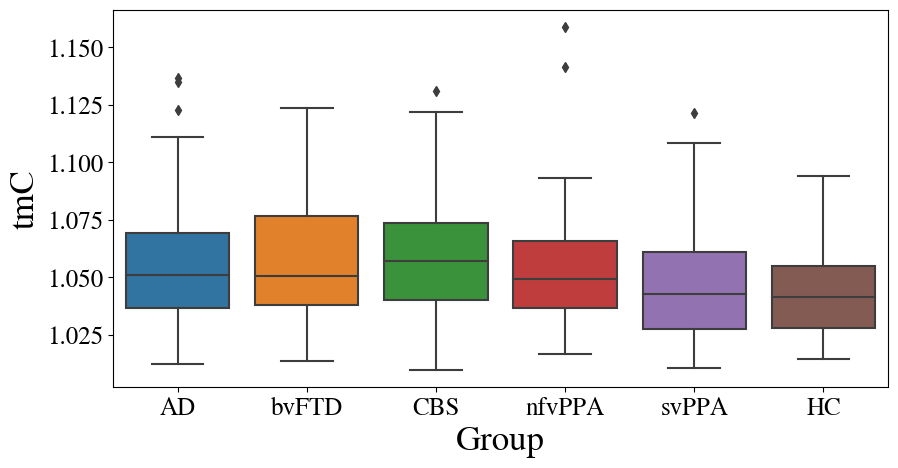

Metric is tmC
+-----------------+--------+-------------+
|            Test |  Pval  | Effect size |
+-----------------+--------+-------------+
|       *AD vs HC |  0.000 |     0.511   |
|    *bvFTD vs HC |  0.001 |     0.615   |
|      *CBS vs HC |  0.001 |     0.683   |
|   *nfvPPA vs HC |  0.003 |     0.576   |
|     svPPA vs HC |  0.254 |     0.219   |
| *Dementia vs HC |  0.000 |     0.452   |
|          *ANOVA |  0.003 |             |
+-----------------+--------+-------------+


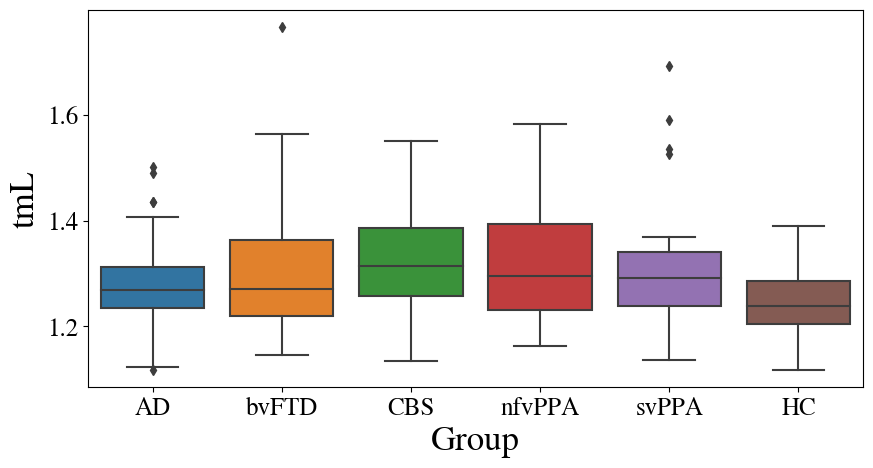

Metric is tmL
+-----------------+--------+-------------+
|            Test |  Pval  | Effect size |
+-----------------+--------+-------------+
|       *AD vs HC |  0.003 |     0.438   |
|    *bvFTD vs HC |  0.000 |     0.642   |
|      *CBS vs HC |  0.000 |     0.974   |
|   *nfvPPA vs HC |  0.000 |     0.828   |
|    *svPPA vs HC |  0.000 |     0.708   |
| *Dementia vs HC |  0.000 |     0.544   |
|          *ANOVA |  0.000 |             |
+-----------------+--------+-------------+


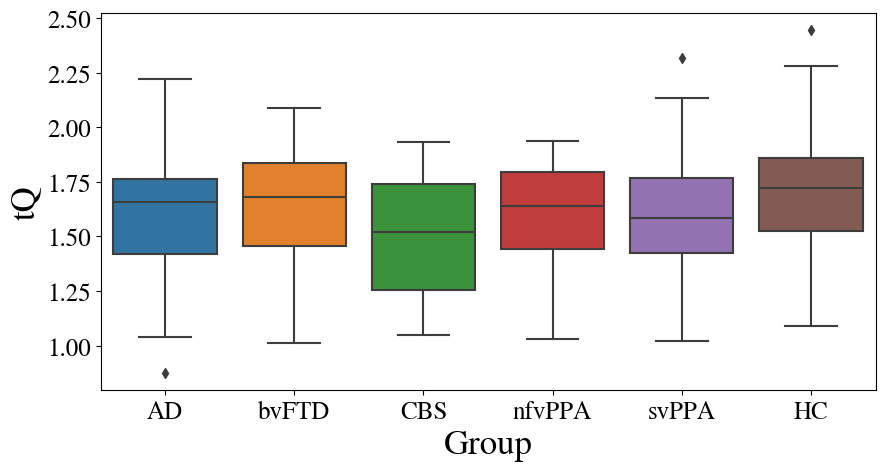

Metric is tQ
+-----------------+--------+-------------+
|            Test |  Pval  | Effect size |
+-----------------+--------+-------------+
|       *AD vs HC |  0.019 |    -0.348   |
|     bvFTD vs HC |  0.054 |    -0.356   |
|      *CBS vs HC |  0.001 |    -0.715   |
|    nfvPPA vs HC |  0.057 |    -0.376   |
|    *svPPA vs HC |  0.025 |    -0.428   |
| *Dementia vs HC |  0.001 |    -0.405   |
|          *ANOVA |  0.012 |             |
+-----------------+--------+-------------+


In [51]:
metric = "tmC"
sub_ixs = np.array([re["sub_ix"] for re in res])
metrics = np.array([re["network_metrics"][metric] for re in res])
metrics = metrics[np.argsort(sub_ixs)]
res_df = pd.DataFrame({
    "metric": metrics, 
    "sex": sex_labs, 
    "diagnosis": diag_labs
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
sns.boxplot(data=res_df, x="diagnosis1", y="metric")
plt.xlabel("Group")
plt.ylabel(f"{metric}")
plt.show()
plt.close()
print(f"Metric is {metric}")
print(_get_test_tb(res_df))

metric = "tmL"
sub_ixs = np.array([re["sub_ix"] for re in res])
metrics = np.array([re["network_metrics"][metric] for re in res])
metrics = metrics[np.argsort(sub_ixs)]
res_df = pd.DataFrame({
    "metric": metrics, 
    "sex": sex_labs, 
    "diagnosis": diag_labs
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
sns.boxplot(data=res_df, x="diagnosis1", y="metric")
plt.xlabel("Group")
plt.ylabel(f"{metric}")
plt.show()
plt.close()
print(f"Metric is {metric}")
print(_get_test_tb(res_df))

metric = "tQ"
sub_ixs = np.array([re["sub_ix"] for re in res])
metrics = np.array([re["network_metrics"][metric] for re in res])
metrics = metrics[np.argsort(sub_ixs)]
res_df = pd.DataFrame({
    "metric": metrics, 
    "sex": sex_labs, 
    "diagnosis": diag_labs
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
sns.boxplot(data=res_df, x="diagnosis1", y="metric")
plt.xlabel("Group")
plt.ylabel(f"{metric}")
plt.show()
plt.close()
print(f"Metric is {metric}")
print(_get_test_tb(res_df))